In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_formatted_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')

universe_age_array_fname = os.path.join(dirname, "times.npy")
universe_age_array = np.load(universe_age_array_fname)

In [3]:
from quenching_time import quenching_indices
from mass_loss import ssfr_t_now

In [4]:
ssfr_matrix = np.zeros_like(histories['sfh'])
for i, t in enumerate(universe_age_array):
    ssfr_matrix[:, i] = ssfr_t_now(histories['sfh'], t)

In [5]:
idx_quenching_times = quenching_indices(ssfr_matrix <= 1e-11)
quenching_times = universe_age_array[idx_quenching_times]
histories['quenching_time'] = quenching_times

# crossmatch with bolplanck halo catalog

In [6]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
halo_id = halocat.halo_table['halo_id']

In [7]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['id'], halocat.halo_table['halo_id'])

In [8]:
histories['upid'] = 0L
histories['upid'][idxA] = halocat.halo_table['halo_upid'][idxB]

In [15]:
quenched_cenmask = (histories['upid'] == -1) & (histories['sfr']/histories['sm'] < 1e-11)
quenched_satmask = (histories['upid'] != -1) & (histories['sfr']/histories['sm'] < 1e-11)

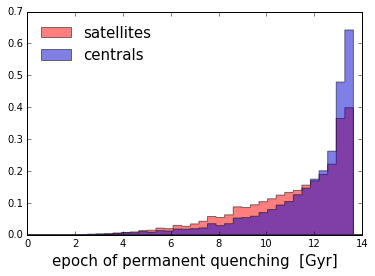

In [37]:
__ = plt.hist(histories['quenching_time'][quenched_satmask], 
              normed=True, bins=np.linspace(0, 14, 40), color='r', 
              histtype='stepfilled', alpha=0.5, label='satellites')

__ = plt.hist(histories['quenching_time'][quenched_cenmask], 
              normed=True, bins=np.linspace(0, 14, 40), color='mediumblue', 
              histtype='stepfilled', alpha=0.5, label='centrals')


plt.xlabel('epoch of permanent quenching  [Gyr]', size=15)
plt.legend(loc='upper left', fontsize=15, frameon=False)